# Dynamic Flux Balance Analysis (dFBA)

- ## Simulation of Batch cultivations under different medium and aeration conditions

In order to simulate A.niger growth in a batch process when producing Oxalic acid over a period we had to employ dFBA approach. 

In [13]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

## 1. CONDITIONS: Glucose and Aerobic


To be able to analyse better the model we set a minimum bound for the biomass reaction in our dfba model. In this case, we set it to 30% of the amount of flux that goes through the biomass reaction. 
Also setting the objective of our dfba model to be the exchange reaction for oxalic acid, the product of interest.

In [14]:
model = read_sbml_model('Model_iJB1325_ATCC1015.xml')

with model:
    model.objective = model.reactions.DRAIN_Biomass
    Biomassobjective = model.optimize().objective_value
    


fba_model = model
fba_model.reactions.DRAIN_Biomass.lower_bound = Biomassobjective*0.3
fba_model.objective = "BOUNDARY_OXALe"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")
Oxal = KineticVariable("Oxalic acid")

dfba_model.add_kinetic_variables([X, Gluc, Oxy, Oxal])

mu = ExchangeFlux("DRAIN_Biomass")
v_G = ExchangeFlux("BOUNDARY_GLCe")
v_O = ExchangeFlux("BOUNDARY_O2e")
v_Ox = ExchangeFlux("BOUNDARY_OXALe")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_Ox])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 0.09398547241492919 * X) 
dfba_model.add_rhs_expression("Oxygen",0) #we keep O2 constant as we know its constantly aerated
dfba_model.add_rhs_expression("Oxalic acid", v_Ox * 30/1000 * X) 

#constant Michaelis Menten parameters (vmaxO2 = 15 and Ko =0.024)

dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15 * (Oxy / (0.024 + Oxy)), Oxy)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05, # (gDW/L)
        "Glucose": 13, # (g/L)
        "Oxygen": 0.2,  # (mmol/L)
        "Oxalic acid": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 13.0, 0.1, ["BOUNDARY_GLCe", "BOUNDARY_O2e", "BOUNDARY_OXALe"])


'' is not a valid SBML 'SId'.


In [15]:
from dfba.plot.matplotlib import *


Plotting the concentrations gives us the following graph:

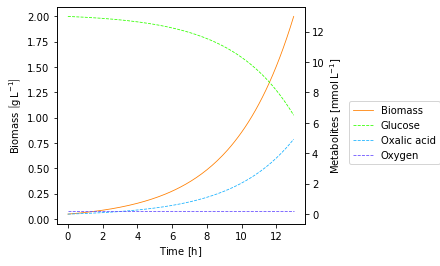

In [16]:
plot_concentrations(concentrations)

As depicted in the above  graph (concentration profile): it can be observed that glucose falls continuously while cells(biomass) are growing. In contrast, Oxalic acid concentration also grows gradually over time. Finally, Oxygen concentration stays constant.

We plot the trajectories

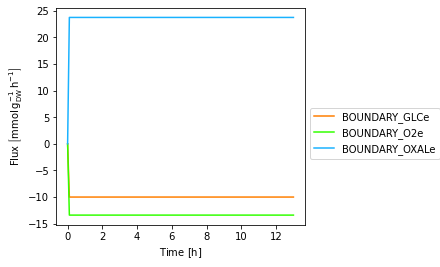

In [17]:
plot_trajectories(trajectories)

As seen in the above graph: 
Oxalic acid flux increases when it is being produced while oxygen and glucose fluxes decrease.

## 2. CONDITIONS: Sucrose and Aerobic

'' is not a valid SBML 'SId'.


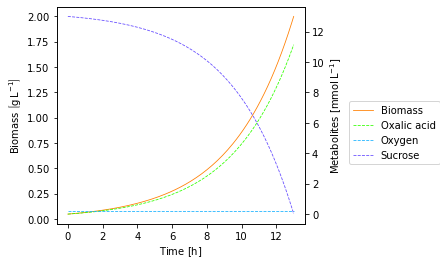

In [18]:
from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
model = read_sbml_model('Model_iJB1325_ATCC1015.xml')

with model:
    model.objective = model.reactions.DRAIN_Biomass
    Biomassobjective = model.optimize().objective_value
    


fba_model = model

medium_SUCe = fba_model.medium
medium_SUCe['BOUNDARY_GLCe']=0
medium_SUCe['BOUNDARY_SUCe']=10
#medium_SUCe['BOUNDARY_O2e']=0
#medium_SUCe['BOUNDARY_SLFe']=0
#medium_SUCe['BOUNDARY_H2Oe']=0
#medium_SUCe['BOUNDARY_HNO3e']=0
#medium_SUCe['BOUNDARY_PIe']=0
#medium_SUCe['BOUNDARY_Ke']=0
#medium_SUCe['BOUNDARY_CAe']=0

fba_model.medium = medium_SUCe

fba_model.reactions.DRAIN_Biomass.lower_bound = Biomassobjective*0.3
fba_model.objective = "BOUNDARY_OXALe"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

X = KineticVariable("Biomass")
Suc = KineticVariable("Sucrose")
Oxy = KineticVariable("Oxygen")
Oxal = KineticVariable("Oxalic acid")

dfba_model.add_kinetic_variables([X, Suc, Oxy, Oxal])

mu = ExchangeFlux("DRAIN_Biomass")
v_S = ExchangeFlux("BOUNDARY_SUCe")
v_O = ExchangeFlux("BOUNDARY_O2e")
v_Ox = ExchangeFlux("BOUNDARY_OXALe")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_S, v_O, v_Ox])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Sucrose", v_S * 0.18797094482984605 * X) 
dfba_model.add_rhs_expression("Oxygen",0) #we keep O2 constant as we know its constantly aerated
dfba_model.add_rhs_expression("Oxalic acid", v_Ox * 30/1000 * X) 

#constant Michaelis Menten parameters (vmaxO2 = 15 and Ko =0.024)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15 * (Oxy / (0.024 + Oxy)), Oxy)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05, # (gDW/L)
        "Sucrose": 13, # (g/L)
        "Oxygen": 0.2,  # (mmol/L)
        "Oxalic acid": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 13.0, 0.1, ["BOUNDARY_SUCe", "BOUNDARY_O2e", "BOUNDARY_OXALe"])
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

As depicted by the above graph, when utilizing sucrose as a carbon source the oxalic acid production increases faster and the biomass curve remains the same as in glucose. Meanwhile sucrose is consumed faster.

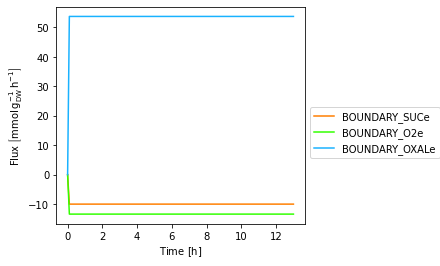

In [19]:
plot_trajectories(trajectories)

# 3. CONDITIONS: Sucrose and Aerobic under different initial conditions than 1&2

'' is not a valid SBML 'SId'.


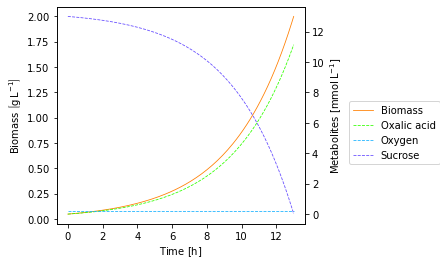

In [20]:

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
model = read_sbml_model('Model_iJB1325_ATCC1015.xml')

with model:
    model.objective = model.reactions.DRAIN_Biomass
    Biomassobjective = model.optimize().objective_value
    


fba_model = model

medium_SUCe = fba_model.medium
medium_SUCe['BOUNDARY_GLCe']=0
medium_SUCe['BOUNDARY_SUCe']=10
#medium_SUCe['BOUNDARY_O2e']=0
#medium_SUCe['BOUNDARY_SLFe']=0
#medium_SUCe['BOUNDARY_H2Oe']=0
#medium_SUCe['BOUNDARY_HNO3e']=0
#medium_SUCe['BOUNDARY_PIe']=0
#medium_SUCe['BOUNDARY_Ke']=0
#medium_SUCe['BOUNDARY_CAe']=0

fba_model.medium = medium_SUCe

fba_model.reactions.DRAIN_Biomass.lower_bound = Biomassobjective*0.3
fba_model.objective = "BOUNDARY_OXALe"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

X = KineticVariable("Biomass")
Suc = KineticVariable("Sucrose")
Oxy = KineticVariable("Oxygen")
Oxal = KineticVariable("Oxalic acid")

dfba_model.add_kinetic_variables([X, Suc, Oxy, Oxal])

mu = ExchangeFlux("DRAIN_Biomass")
v_S = ExchangeFlux("BOUNDARY_SUCe")
v_O = ExchangeFlux("BOUNDARY_O2e")
v_Ox = ExchangeFlux("BOUNDARY_OXALe")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_S, v_O, v_Ox])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Sucrose", v_S * 0.18797094482984605 * X) 
dfba_model.add_rhs_expression("Oxygen",0) #we keep O2 constant as we know its constantly aerated
dfba_model.add_rhs_expression("Oxalic acid", v_Ox * 30/1000 * X) 

#constant Michaelis Menten parameters (vmaxO2 = 15 and Ko =0.024)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15 * (Oxy / (0.024 + Oxy)), Oxy)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05, # (gDW/L)
        "Sucrose": 13, # (g/L)
        "Oxygen": 0.2,  # (mmol/L)
        "Oxalic acid": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 13.0, 0.1, ["BOUNDARY_SUCe", "BOUNDARY_O2e", "BOUNDARY_OXALe"])
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

As observed, changing the initial conditions completly changes the batch results

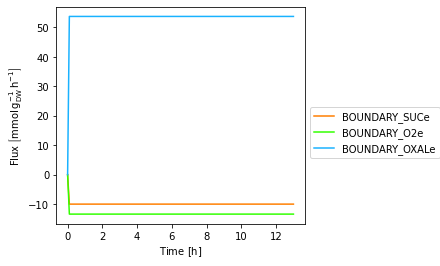

In [21]:
plot_trajectories(trajectories)

# 4. CONDITIONS: Lactose and Aerobic under different initial conditions than 1&2

'' is not a valid SBML 'SId'.


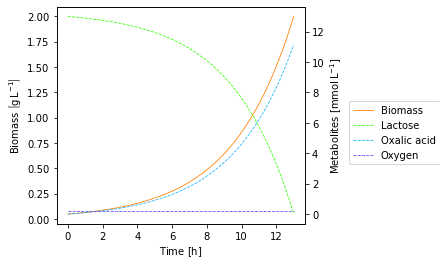

In [22]:

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
model = read_sbml_model('Model_iJB1325_ATCC1015.xml')

with model:
    model.objective = model.reactions.DRAIN_Biomass
    Biomassobjective = model.optimize().objective_value
    

fba_model = model

medium_SUCe = fba_model.medium
medium_SUCe['BOUNDARY_GLCe']=0
medium_SUCe['BOUNDARY_LACTe']=10
#medium_SUCe['BOUNDARY_O2e']=0
#medium_SUCe['BOUNDARY_SLFe']=0
#medium_SUCe['BOUNDARY_H2Oe']=0
#medium_SUCe['BOUNDARY_HNO3e']=0
#medium_SUCe['BOUNDARY_PIe']=0
#medium_SUCe['BOUNDARY_Ke']=0
#medium_SUCe['BOUNDARY_CAe']=0

fba_model.medium = medium_SUCe

fba_model.reactions.DRAIN_Biomass.lower_bound = Biomassobjective*0.3
fba_model.objective = "BOUNDARY_OXALe"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

X = KineticVariable("Biomass")
Lac = KineticVariable("Lactose")
Oxy = KineticVariable("Oxygen")
Oxal = KineticVariable("Oxalic acid")

dfba_model.add_kinetic_variables([X, Lac, Oxy, Oxal])

mu = ExchangeFlux("DRAIN_Biomass")
v_L = ExchangeFlux("BOUNDARY_LACTe")
v_O = ExchangeFlux("BOUNDARY_O2e")
v_Ox = ExchangeFlux("BOUNDARY_OXALe")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_L, v_O, v_Ox])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Lactose", v_L * 0.18797094482984605 * X) 
dfba_model.add_rhs_expression("Oxygen",0) #we keep O2 constant as we know its constantly aerated
dfba_model.add_rhs_expression("Oxalic acid", v_Ox * 30/1000 * X) 

#constant Michaelis Menten parameters (vmaxO2 = 15 and Ko =0.024)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15 * (Oxy / (0.024 + Oxy)), Oxy)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05, # (gDW/L)
        "Lactose": 13, # (g/L)
        "Oxygen": 0.2,  # (mmol/L)
        "Oxalic acid": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 13.0, 0.1, ["BOUNDARY_LACTe", "BOUNDARY_O2e", "BOUNDARY_OXALe"])
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

As seen from the graph Lactose and Sucrose behave exactly in the same pattern

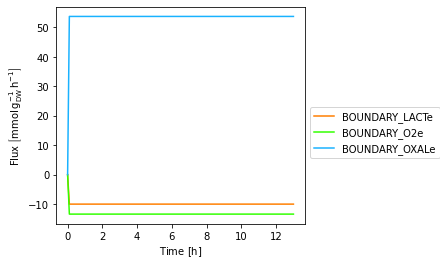

In [23]:
plot_trajectories(trajectories)

# 5. CONDITIONS: Sucrose and Anaerobic 


'' is not a valid SBML 'SId'.


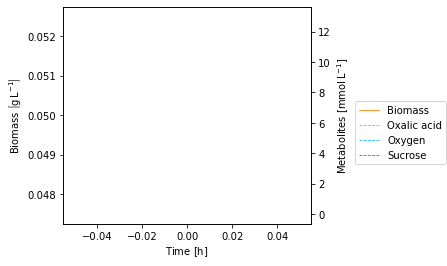

In [24]:
from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
model = read_sbml_model('Model_iJB1325_ATCC1015.xml')

with model:
    model.objective = model.reactions.DRAIN_Biomass
    Biomassobjective = model.optimize().objective_value
    



fba_model = model

medium_SUCe = fba_model.medium
medium_SUCe['BOUNDARY_GLCe']=0
medium_SUCe['BOUNDARY_SUCe']=10
medium_SUCe['BOUNDARY_O2e']=0
#medium_SUCe['BOUNDARY_SLFe']=0
#medium_SUCe['BOUNDARY_H2Oe']=0
#medium_SUCe['BOUNDARY_HNO3e']=0
#medium_SUCe['BOUNDARY_PIe']=0
#medium_SUCe['BOUNDARY_Ke']=0
#medium_SUCe['BOUNDARY_CAe']=0

fba_model.medium = medium_SUCe

fba_model.reactions.DRAIN_Biomass.lower_bound = Biomassobjective*0.3
fba_model.objective = "BOUNDARY_OXALe"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

X = KineticVariable("Biomass")
Suc = KineticVariable("Sucrose")
Oxy = KineticVariable("Oxygen")
Oxal = KineticVariable("Oxalic acid")

dfba_model.add_kinetic_variables([X, Suc, Oxy, Oxal])

mu = ExchangeFlux("DRAIN_Biomass")
v_S = ExchangeFlux("BOUNDARY_SUCe")
v_O = ExchangeFlux("BOUNDARY_O2e")
v_Ox = ExchangeFlux("BOUNDARY_OXALe")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_S, v_O, v_Ox])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Sucrose", v_S * 0.18797094482984605 * X)
dfba_model.add_rhs_expression("Oxygen",0) #we keep O2 constant as we know its constantly aerated
dfba_model.add_rhs_expression("Oxalic acid", v_Ox * 30/1000 * X) 

#constant Michaelis Menten parameters (vmaxO2 = 15 and Ko =0.024)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15 * (Oxy / (0.024 + Oxy)), Oxy)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05, # (gDW/L)
        "Sucrose": 13, # (g/L)
        "Oxygen": 0.0,  # (mmol/L)
        "Oxalic acid": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 13.0, 0.1, ["BOUNDARY_SUCe", "BOUNDARY_O2e", "BOUNDARY_OXALe"])
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

As expected, when oxygen is eliminated from the system A.niger does not grow and the batch cultivation can not proceed.